In [1]:
import librosa
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from tensorflow.contrib import keras
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from sklearn import preprocessing
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

## Preprocessing

In [75]:
le = preprocessing.LabelEncoder()
encoder_is_fit = False

def extract_feature(file_name, printLog = False):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0) # stft used
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0) # stft used
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
      sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    if printLog:
      print('sample rate = %s'%sample_rate)
      print('mfccs shape = %s'%mfccs.shape)
      print('chroma shape = %s'%chroma.shape)
      print('mel shape = %s'%mel.shape)
      print('contrast shape = %s'%contrast.shape)
      print('tonnetz shape = %s'%tonnetz.shape)
    return ext_features

def parse_audio_files(root_path, log=False):
    fts, labels = np.empty((0,193), dtype=np.float32), np.empty((0))
    folders = (os.path.join(root_path,f) for f in os.listdir(root_path) 
                  if (os.path.isdir(os.path.join(root_path,f)) and not f.startswith('.')
                     and not f.startswith('hawker')))
    for fldr in folders:
        wave_files = (os.path.join(fldr, f) for f in os.listdir(fldr) if (f.endswith('.wav') 
            and os.path.isfile(os.path.join(fldr, f))))
        if log:
          print('\n\nnavigating in the folder = %s'%str(fldr))
        for f in wave_files:
              if log:
                print(str(f))
              ext_features = extract_feature(f)
              fts = np.vstack([fts,ext_features])
              labels = np.append(labels, os.path.basename(fldr))
    return fts,labels

def one_hot_encode(labels, force_fit=False):
    global encoder_is_fit
    global encoded_labels
    if force_fit or not encoder_is_fit:
        encoded_labels = le.fit_transform(labels)
        encoder_is_fit = True
    else:
        encoded_labels = le.transform(labels)
    one_hot_encode = keras.utils.to_categorical(encoded_labels)
    return one_hot_encode

In [76]:
def printFeatureDetails(wave_file_path):
    if os.path.exists(wave_file_path):
        x,y = librosa.load(wave_file_path)
        stft = np.abs(librosa.stft(x))
        chroma = librosa.feature.chroma_stft(S=stft, sr=y)
        print('x.shape = %s, y = %d'%(str(x.shape), y))
        print('stft.shape = %s'%str(stft.shape))
        print('chroma.shape = %s'%str(chroma.shape))
    else:
        print('file \'%s\' doesn\'t exist'%wave_file_path)

In [77]:
np.random.seed(341136787)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [78]:
#define paths
root_path_large = 'sounds/recorded/large'
root_path_small = 'sounds/recorded/small'

#extract features
train_x, train_y = parse_audio_files(root_path_large)
test_x, test_y = parse_audio_files(root_path_small)

In [79]:
#randomize
train_x, train_y = randomize(train_x, train_y)
test_x, test_y = randomize(test_x, test_y)

#one hot encode the labels
train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)

## Save pickle

In [80]:
# dump to pickle
if os.environ['HOME'] == '/Users/Gundeep':
    pickle_filename = '/Users/Gundeep/Projects/Punjabi/punjabi_pickle_large.pickle'
else:
    pickle_filename = '/home/paperspace/Documents/Projects/Punjabi/punjabi_pickle.pickle'
pickle_dump = {'train_x' : train_x,
               'train_y' : train_y,
               'test_x' : test_x,
               'test_y' : test_y}
import pickle
try:
  with open(pickle_filename, 'wb') as f:
    pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
  print('Unable to save data to', pickle_filename, ':', e)

In [81]:
os.environ['HOME']

'/Users/Gundeep'

## Load pickle

In [2]:
# load from pickle
import pickle
pickle_filename = ''
if os.environ['HOME'] == '/Users/Gundeep':
    pickle_filename = '/Users/Gundeep/Projects/Punjabi/punjabi_pickle_large.pickle'
else:
    pickle_filename = '/home/paperspace/Documents/Projects/Punjabi/punjabi_pickle.pickle'
pickle_dump = {}
try:
  with open(pickle_filename, 'rb') as f:
    pickle_dump = pickle.load(f)
except Exception as e:
  print('Unable to load pickle', pickle_filename, ':', e)

In [3]:
train_x = pickle_dump['train_x']
train_y = pickle_dump['train_y']
test_x = pickle_dump['test_x']
test_y = pickle_dump['test_y']

In [4]:
print('train_x.shape = %s'%str(train_x.shape))
print('train_y.shape = %s'%str(train_y.shape))
print('test_x.shape = %s'%str(test_x.shape))
print('test_y.shape = %s'%str(test_y.shape))

train_x.shape = (8442, 193)
train_y.shape = (8442, 9)
test_x.shape = (1197, 193)
test_y.shape = (1197, 9)


## Model Training

In [5]:
#hyper paramters
training_epochs = 2000
n_dim = train_x.shape[1]
b_size = 20
n_classes = 9
n_hidden_units_one = 280
n_hidden_units_two = 300
n_hidden_units_three = 128
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.005

In [6]:
n_classes

9

In [7]:
Sequential = models.Sequential
Dense = layers.Dense
#numpy.random.seed(7)

In [8]:
model = None
model = Sequential()
model.add(Dense(n_hidden_units_one, input_dim=n_dim, activation='relu'))
model.add(Dense(n_hidden_units_two, activation='tanh'))
model.add(Dense(n_hidden_units_two, activation='relu'))
model.add(Dense(n_hidden_units_three, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=training_epochs, batch_size=b_size)

Epoch 1/2000
8442/8442 [==============================] - 1s - loss: 0.3199 - acc: 0.8903     
Epoch 2/2000
8442/8442 [==============================] - 1s - loss: 0.2657 - acc: 0.8963     
Epoch 3/2000
8442/8442 [==============================] - 1s - loss: 0.2463 - acc: 0.8999     
Epoch 4/2000
8442/8442 [==============================] - 2s - loss: 0.1990 - acc: 0.9133     
Epoch 5/2000
8442/8442 [==============================] - 2s - loss: 0.1640 - acc: 0.9268     
Epoch 6/2000
8442/8442 [==============================] - 2s - loss: 0.1314 - acc: 0.9395     
Epoch 7/2000
8442/8442 [==============================] - 2s - loss: 0.0913 - acc: 0.9621     
Epoch 8/2000
8442/8442 [==============================] - 2s - loss: 0.0438 - acc: 0.9854     
Epoch 9/2000
8442/8442 [==============================] - 2s - loss: 0.0218 - acc: 0.9931     
Epoch 10/2000
8442/8442 [==============================] - 2s - loss: 0.0214 - acc: 0.9936     
Epoch 11/2000
8442/8442 [========================

8442/8442 [==============================] - 2s - loss: 1.0381e-07 - acc: 1.0000     
Epoch 165/2000
8442/8442 [==============================] - 2s - loss: 1.0340e-07 - acc: 1.0000     
Epoch 166/2000
8442/8442 [==============================] - 3s - loss: 1.0318e-07 - acc: 1.0000     
Epoch 167/2000
8442/8442 [==============================] - 3s - loss: 1.0295e-07 - acc: 1.0000     
Epoch 168/2000
8442/8442 [==============================] - 3s - loss: 1.0277e-07 - acc: 1.0000     
Epoch 169/2000
8442/8442 [==============================] - 2s - loss: 1.0269e-07 - acc: 1.0000     
Epoch 170/2000
8442/8442 [==============================] - 2s - loss: 1.0265e-07 - acc: 1.0000     
Epoch 171/2000
8442/8442 [==============================] - 2s - loss: 1.0262e-07 - acc: 1.0000     
Epoch 172/2000
8442/8442 [==============================] - 2s - loss: 1.0248e-07 - acc: 1.0000     
Epoch 173/2000
8442/8442 [==============================] - 2s - loss: 1.0237e-07 - acc: 1.0000     
Epoch

8442/8442 [==============================] - 3s - loss: 4.1988e-07 - acc: 1.0000     
Epoch 325/2000
8442/8442 [==============================] - 3s - loss: 3.6538e-07 - acc: 1.0000     
Epoch 326/2000
8442/8442 [==============================] - 4s - loss: 3.1424e-07 - acc: 1.0000     
Epoch 327/2000
8442/8442 [==============================] - 4s - loss: 2.6789e-07 - acc: 1.0000     
Epoch 328/2000
8442/8442 [==============================] - 4s - loss: 2.3244e-07 - acc: 1.0000     
Epoch 329/2000
8442/8442 [==============================] - 4s - loss: 2.0291e-07 - acc: 1.0000     
Epoch 330/2000
8442/8442 [==============================] - 3s - loss: 1.8254e-07 - acc: 1.0000     
Epoch 331/2000
8442/8442 [==============================] - 4s - loss: 1.6354e-07 - acc: 1.0000     
Epoch 332/2000
8442/8442 [==============================] - 3s - loss: 1.5106e-07 - acc: 1.0000     
Epoch 333/2000
8442/8442 [==============================] - 3s - loss: 1.4066e-07 - acc: 1.0000     
Epoch

8442/8442 [==============================] - 2s - loss: 1.0215e-07 - acc: 1.0000     
Epoch 487/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 488/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 489/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 490/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 491/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 492/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 493/2000
8442/8442 [==============================] - 2s - loss: 0.0180 - acc: 0.9943     
Epoch 494/2000
8442/8442 [==============================] - 2s - loss: 2.8390e-04 - acc: 1.0000     
Epoch 495/2000
8442/8442 [==============================] - 2s - loss: 7.6015e-05 - acc: 1.0000     
Epoch 496

8442/8442 [==============================] - 2s - loss: 3.3565e-07 - acc: 1.0000     
Epoch 648/2000
8442/8442 [==============================] - 2s - loss: 2.9792e-07 - acc: 1.0000     
Epoch 649/2000
8442/8442 [==============================] - 2s - loss: 2.6628e-07 - acc: 1.0000     
Epoch 650/2000
8442/8442 [==============================] - 2s - loss: 2.4047e-07 - acc: 1.0000     
Epoch 651/2000
8442/8442 [==============================] - 2s - loss: 2.1668e-07 - acc: 1.0000     
Epoch 652/2000
8442/8442 [==============================] - 2s - loss: 2.1264e-07 - acc: 1.0000     
Epoch 653/2000
8442/8442 [==============================] - 2s - loss: 1.9301e-07 - acc: 1.0000     
Epoch 654/2000
8442/8442 [==============================] - 2s - loss: 1.8207e-07 - acc: 1.0000     
Epoch 655/2000
8442/8442 [==============================] - 2s - loss: 1.7238e-07 - acc: 1.0000     
Epoch 656/2000
8442/8442 [==============================] - 2s - loss: 1.6399e-07 - acc: 1.0000     
Epoch

8442/8442 [==============================] - 2s - loss: 1.0215e-07 - acc: 1.0000     
Epoch 809/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 810/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 811/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 812/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 813/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 814/2000
8442/8442 [==============================] - 2s - loss: 1.0214e-07 - acc: 1.0000     
Epoch 815/2000
8442/8442 [==============================] - 2s - loss: 0.0220 - acc: 0.9947     
Epoch 816/2000
8442/8442 [==============================] - 2s - loss: 1.7095e-04 - acc: 1.0000     
Epoch 817/2000
8442/8442 [==============================] - 2s - loss: 5.9055e-05 - acc: 1.0000     
Epoch 818

8442/8442 [==============================] - 2s - loss: 1.1062e-07 - acc: 1.0000     
Epoch 971/2000
8442/8442 [==============================] - 2s - loss: 1.0947e-07 - acc: 1.0000     
Epoch 972/2000
8442/8442 [==============================] - 2s - loss: 1.0834e-07 - acc: 1.0000     
Epoch 973/2000
8442/8442 [==============================] - 2s - loss: 1.0749e-07 - acc: 1.0000     
Epoch 974/2000
8442/8442 [==============================] - 2s - loss: 1.0663e-07 - acc: 1.0000     
Epoch 975/2000
8442/8442 [==============================] - 2s - loss: 1.0583e-07 - acc: 1.0000     
Epoch 976/2000
8442/8442 [==============================] - 2s - loss: 1.0525e-07 - acc: 1.0000     
Epoch 977/2000
8442/8442 [==============================] - 2s - loss: 1.0476e-07 - acc: 1.0000     
Epoch 978/2000
8442/8442 [==============================] - 2s - loss: 1.0436e-07 - acc: 1.0000     
Epoch 979/2000
8442/8442 [==============================] - 2s - loss: 1.0403e-07 - acc: 1.0000     
Epoch

8442/8442 [==============================] - 2s - loss: 2.1161e-05 - acc: 1.0000     
Epoch 1131/2000
8442/8442 [==============================] - 2s - loss: 1.3340e-05 - acc: 1.0000     
Epoch 1132/2000
8442/8442 [==============================] - 2s - loss: 8.2843e-06 - acc: 1.0000     
Epoch 1133/2000
8442/8442 [==============================] - 2s - loss: 6.6105e-06 - acc: 1.0000     
Epoch 1134/2000
8442/8442 [==============================] - 2s - loss: 4.7315e-06 - acc: 1.0000     
Epoch 1135/2000
8442/8442 [==============================] - 1s - loss: 3.7480e-06 - acc: 1.0000     
Epoch 1136/2000
8442/8442 [==============================] - 1s - loss: 3.0469e-06 - acc: 1.0000     
Epoch 1137/2000
8442/8442 [==============================] - 1s - loss: 3.3994e-06 - acc: 1.0000     
Epoch 1138/2000
8442/8442 [==============================] - 2s - loss: 2.1117e-06 - acc: 1.0000     
Epoch 1139/2000
8442/8442 [==============================] - 2s - loss: 1.8357e-06 - acc: 1.0000  

8442/8442 [==============================] - 1s - loss: 1.0267e-07 - acc: 1.0000     
Epoch 1291/2000
8442/8442 [==============================] - 1s - loss: 1.0260e-07 - acc: 1.0000     
Epoch 1292/2000
8442/8442 [==============================] - 1s - loss: 1.0254e-07 - acc: 1.0000     
Epoch 1293/2000
8442/8442 [==============================] - 1s - loss: 1.0249e-07 - acc: 1.0000     
Epoch 1294/2000
8442/8442 [==============================] - 1s - loss: 0.0300 - acc: 0.9935     
Epoch 1295/2000
8442/8442 [==============================] - 2s - loss: 9.4041e-04 - acc: 0.9997     
Epoch 1296/2000
8442/8442 [==============================] - 1s - loss: 1.3228e-05 - acc: 1.0000     
Epoch 1297/2000
8442/8442 [==============================] - 2s - loss: 6.9858e-06 - acc: 1.0000     
Epoch 1298/2000
8442/8442 [==============================] - 1s - loss: 3.9166e-06 - acc: 1.0000     
Epoch 1299/2000
8442/8442 [==============================] - 2s - loss: 2.5529e-06 - acc: 1.0000     


8442/8442 [==============================] - 1s - loss: 1.0279e-07 - acc: 1.0000     
Epoch 1451/2000
8442/8442 [==============================] - 1s - loss: 1.0286e-07 - acc: 1.0000     
Epoch 1452/2000
8442/8442 [==============================] - 1s - loss: 1.0244e-07 - acc: 1.0000     
Epoch 1453/2000
8442/8442 [==============================] - 1s - loss: 1.0241e-07 - acc: 1.0000     
Epoch 1454/2000
8442/8442 [==============================] - 1s - loss: 1.0235e-07 - acc: 1.0000     
Epoch 1455/2000
8442/8442 [==============================] - 1s - loss: 1.0230e-07 - acc: 1.0000     
Epoch 1456/2000
8442/8442 [==============================] - 1s - loss: 1.0227e-07 - acc: 1.0000     
Epoch 1457/2000
8442/8442 [==============================] - 1s - loss: 1.0223e-07 - acc: 1.0000     
Epoch 1458/2000
8442/8442 [==============================] - 1s - loss: 1.0221e-07 - acc: 1.0000     
Epoch 1459/2000
8442/8442 [==============================] - 1s - loss: 1.0219e-07 - acc: 1.0000  

8442/8442 [==============================] - 1s - loss: 4.8156e-06 - acc: 1.0000     
Epoch 1611/2000
8442/8442 [==============================] - 1s - loss: 3.8772e-06 - acc: 1.0000     
Epoch 1612/2000
8442/8442 [==============================] - 1s - loss: 3.1301e-06 - acc: 1.0000     
Epoch 1613/2000
8442/8442 [==============================] - 1s - loss: 2.6379e-06 - acc: 1.0000     
Epoch 1614/2000
8442/8442 [==============================] - 1s - loss: 2.2697e-06 - acc: 1.0000     
Epoch 1615/2000
8442/8442 [==============================] - 1s - loss: 1.9793e-06 - acc: 1.0000     
Epoch 1616/2000
8442/8442 [==============================] - 1s - loss: 1.7081e-06 - acc: 1.0000     
Epoch 1617/2000
8442/8442 [==============================] - 1s - loss: 1.4906e-06 - acc: 1.0000     
Epoch 1618/2000
8442/8442 [==============================] - 1s - loss: 1.2932e-06 - acc: 1.0000     
Epoch 1619/2000
8442/8442 [==============================] - 1s - loss: 1.0700e-06 - acc: 1.0000  

8442/8442 [==============================] - 1s - loss: 1.2281e-06 - acc: 1.0000     
Epoch 1771/2000
8442/8442 [==============================] - 1s - loss: 9.2720e-07 - acc: 1.0000     
Epoch 1772/2000
8442/8442 [==============================] - 1s - loss: 8.2155e-07 - acc: 1.0000     
Epoch 1773/2000
8442/8442 [==============================] - 1s - loss: 7.3261e-07 - acc: 1.0000     
Epoch 1774/2000
8442/8442 [==============================] - 1s - loss: 6.3508e-07 - acc: 1.0000     
Epoch 1775/2000
8442/8442 [==============================] - 1s - loss: 5.3900e-07 - acc: 1.0000     
Epoch 1776/2000
8442/8442 [==============================] - 1s - loss: 4.4551e-07 - acc: 1.0000     
Epoch 1777/2000
8442/8442 [==============================] - 1s - loss: 3.8697e-07 - acc: 1.0000     
Epoch 1778/2000
8442/8442 [==============================] - 1s - loss: 3.3248e-07 - acc: 1.0000     
Epoch 1779/2000
8442/8442 [==============================] - 1s - loss: 3.0883e-07 - acc: 1.0000  

In [ ]:
test_x.shape

In [ ]:
scores = model.evaluate(test_x, test_y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
model.summary()

In [ ]:
def updateTestData():
    test_x, test_y = parse_audio_files(root_path_small)
    test_x, test_y = randomize(test_x, test_y)
    test_y = one_hot_encode(test_y)
    return test_x,test_y

def run_prediction(update=False):
    global test_x,test_y
    if update:
        test_x, test_y = updateTestData()
    y_prob = model.predict(test_x)
    y_classes = y_prob.argmax(axis=-1)
    print(y_classes)
    print(test_y)
    correct = np.sum((np.where(test_y == 1)[1] == y_classes).astype(np.int8),0)
    wrong = np.sum((np.where(test_y == 1)[1] != y_classes).astype(np.int8),0)
    print('correctly predicted = %s'%correct)
    print('incorrectly predicted = %s'%wrong)

In [ ]:
run_prediction(update=False)

## Generate Extensive Dataset

In [65]:
import wave

import numpy
sr = 22050 # sample rate
T = 0.125    # seconds
freq = 0 # for empty sound
π = numpy.pi
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
half_empty = 0.5*numpy.sin(2*π*freq*t)
one_empty = np.append(half_empty, half_empty)
quarter_sample_shape = int(half_empty.shape[0] / 2)

def write_file(X, name, ext, uid):
    new_filename = "{name}{uid}{ext}".format(name=name, uid=uid, ext=ext)
    librosa.output.write_wav(new_filename, X, sr)
    print('file created - %s'%new_filename)
    
def create_trimmed_file(filename):
    X, sample_rate = librosa.load(filename)
    if(sample_rate != sr):
        print('\x1b[5;30;41m' + 'Please check the sampling rate' + '\x1b[0m')
        return
        
    # get the samples to be padded
    name, ext = os.path.splitext(filename)
    
    # translate with empty padding
    X1 = X[:-1*half_empty.shape[0]]
    uid='_right_trimmed'
    write_file(X1, name, ext, uid)
    
    X2 = X[:-1*one_empty.shape[0]]
    uid='_right_2_trimmed'
    write_file(X2, name, ext, uid)
    
    X3 = X[half_empty.shape[0]:]
    uid='_left_trimmed'
    write_file(X3, name, ext, uid)
    
    X4 = X[one_empty.shape[0]:]
    uid='_left_2_trimmed'
    write_file(X4, name, ext, uid)
    
    X5 = X[one_empty.shape[0]:-1*one_empty.shape[0]]
    uid='lr_2_trimmed'
    write_file(X5, name, ext, uid)
    
    X6 = X[half_empty.shape[0]:-1*half_empty.shape[0]]
    uid='lr_trimmed'
    write_file(X6, name, ext, uid)

# iterate over all files
def translate_file(filename):

    X, sample_rate = librosa.load(filename)
    if(sample_rate != sr):
        print('\x1b[5;30;41m' + 'Please check the sampling rate' + '\x1b[0m')
        return
        
    # get the samples to be padded
    name, ext = os.path.splitext(filename)
    quarter_sample = X[-1*quarter_sample_shape:]
    half_sample = np.append(quarter_sample, quarter_sample)
    one_sample = np.append(half_sample, half_sample)
    
    # translate with empty padding
    X1 = np.append(half_empty, X[:-1*half_empty.shape[0]])
    uid='_right_e'
    write_file(X1, name, ext, uid)
    
    X2 = np.append(one_empty, X[:-1*one_empty.shape[0]])
    uid='_right_2_e'
    write_file(X2, name, ext, uid)
    
    X3 = np.append(X[half_empty.shape[0]:], half_empty)
    uid='_left_e'
    write_file(X3, name, ext, uid)
    X4 = np.append(X[one_empty.shape[0]:], one_empty)
    uid='_left_2_e'
    write_file(X4, name, ext, uid)
    
    #translate with audio ending used as padding
    X5 = np.append(half_sample, X[:-1*half_sample.shape[0]])
    uid='_right'
    write_file(X5, name, ext, uid)
    
    X6 = np.append(one_sample, X[:-1*one_sample.shape[0]])
    uid='_right_2'
    write_file(X6, name, ext, uid)
    
    X7 = np.append(X[half_sample.shape[0]:], half_sample)
    uid='_left'
    write_file(X7, name, ext, uid)
    
    X8 = np.append(X[one_sample.shape[0]:], one_sample)
    uid='_left_2'
    write_file(X8, name, ext, uid)

In [4]:
import matplotlib.pyplot as plt
import librosa.display
import os

def plot_spec(filename):
    print('filename=%s'%filename)
    x, sr = librosa.load(filename)
    plt.figure(figsize=(20, 2))
    plt.title = os.path.basename(os.path.splitext(filename)[0])
    librosa.display.waveplot(x, sr=sr)
    plt.show

filename=../notebook/sounds/recorded/large/ah_gana_download_kar/10.wav


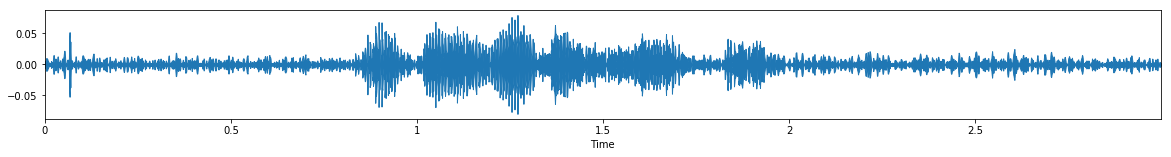

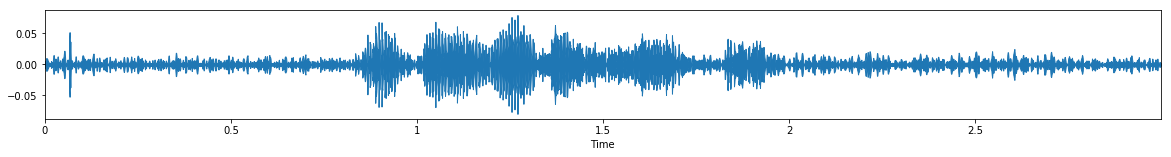

In [6]:
plot_spec('../notebook/sounds/recorded/large/ah_gana_download_kar/10.wav')
plt.show()

In [69]:
def translate_all_files(root_path):
    file_ext = '*.wav'
    count = 0
    for file in glob.glob(os.path.join(root_path, file_ext)):
        translate_file(os.path.join(root_path, file))
        count=count+1
        print('translated %d files'%count)
        
def trim_all_files(root_path):
    file_ext = '*.wav'
    count = 0
    for file in glob.glob(os.path.join(root_path, file_ext)):
        create_trimmed_file(os.path.join(root_path, file))
        count=count+1
        print('trimmed %d files'%count)

In [73]:
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/') #1
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/') #2
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/') #3
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/') #4
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/') #5
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/') #6
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/') #7
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/') #8
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/') #9

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1_left_2.wav
translated 1 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_bo

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/12_right_2_trimmed_left_2.wav
translated 19 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_dr

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2_left_2.wav
translated 29 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_b

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/36_new_right_trimmed_left_2.wav
translated 48 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/record

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/4_left_2.wav
translated 57 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_b

translated 65 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_left_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/5_

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/7lr_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/7lr_trimmed_left_2.wav
translated 84 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/record

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/8_new_right_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_so

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/1_left_2.wav
translated 1 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/10_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/s

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_clean_left_2.wav
translated 16 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/14_cle

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2_left_2.wav
translated 36 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/22_new_right_e.wav
file created - /Users/Gundeep/Dropbox/noteb

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_2_trimmed_left_2.wav
translated 48 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/2lr_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/4_left_2.wav
translated 64 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/40_new_right_e.wav
file created - /Users/Gundeep/Dropbox/noteb

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_left_2.wav
translated 79 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_left_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/47_new_left_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/larg

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_left_2.wav
translated 92 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_clean_right_e.wav
file created - /Users/Gundeep/Dropbox/note

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/5_unclean_left_2.wav
translated 104 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_k

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left_2.wav
translated 113 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/6_left_2_trimmed

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/7_right_2_trimmed_left_2.wav
translated 123 files
file created - /Users/G

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/8lr_trimmed_left_2.wav
translated 133 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_left_2.wav
translated 2 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/10_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorde

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_left_2.wav
translated 16 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/13_clean_left_2_trimmed_right_e.wav
file c

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_left_2.wav
translated 30 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/15_clean_left_2_trimmed_right_e.wav
file c

translated 48 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/1lr_trimmed_left_2.wav
translated 49 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_ka

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_left_2.wav
translated 64 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/3_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/

translated 80 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/5_right_2_trimmed_left_2.wav
translated 81 files
file created - /Users/Gundeep/Dropbo

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/7_right_2_trimmed_left_2.wav
translated 95 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/re

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_2_trimmed_left_2.wav
translated 111 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/9lr

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_left_2.wav
translated 15 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/2_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/soun

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_left_2.wav
translated 30 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/48_new_left_2_trimmed_right_e.wav
file c

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_2_trimmed_left_2.wav
translated 38 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/49_new_left_trimmed_left.wav
file created - /Users/

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_left_2.wav
translated 50 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/5_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/soun

translated 67 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/7_clean_right_trimmed_left_2.wav
translat

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/8_left_2_trimmed_left_2.wav
translated 79 files
file created - /Users/Gundeep/Dropbox/notebook/s

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_2_trimmed_left_2.wav
translated 88 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/9_right_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11_right_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11_right_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11_right_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11_right_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11_right_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11_right_trimmed_left_2.wav
translated 13 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11lr_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11lr_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/11lr_2_trimmed_left_e.wav
f

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_left_2.wav
translated 30 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/32_new_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_left_2.wav
translated 43 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/4_left_2_trimmed_right_2_e.wav
fi

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5_right_trimmed_left_2.wav
translated 54 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/5lr_2_trimmed_right_e.wav
file 

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_left_2.wav
translated 64 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/8_left_2_trimmed_right_2_e.wav
fi

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2.wav
translated 1 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/10_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_aj

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/12lr_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/12lr_trimmed_left_2.wav
translated 22 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/1_left_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mau

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/3_left_2_trimmed_left_2.wav
translated 44 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/l

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_2_trimmed_left_2.wav
translated 65 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/5_left_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/lar

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/6lr_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/6lr_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/6lr_trimmed_left_2.wav
translated 77 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/7_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/7_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/7_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/7_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/7_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/7_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_left_2.wav
translated 92 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/9_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/10lr_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/10lr_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/10lr_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/10lr_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/10lr_trimmed_left_2.wav
translated 8 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/11_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/11_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/11_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/23_new_left_2.wav
translated 23 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/l

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_left_2.wav
translated 36 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/3_left_2

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_2_trimmed_left_2.wav
translated 48 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/4lr_trimmed_right_2.wav
file created - /User

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_left_2.wav
translated 71 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/9_left_2

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_left_2.wav
translated 12 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/10_new_left_2_trimmed_right_e.wav
file created - 

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/11_right_2_trimmed_left_2.wav
translated 26 files
file created - /Users/Gundeep/Dropbox/no

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_left_2.wav
translated 37 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/27_new_left_2_trimmed_right_e.wav
file created - 

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_left_2.wav
translated 51 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/29_new_left_2_trimmed_right_e.wav
file created - 

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_left_2.wav
translated 65 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/30_new_left_2_trimmed_right_e.wav
file created - 

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_left_trimmed_left_2.wav
translated 80 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/3_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/soun

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/5_right_2_trimmed_left_2.wav
translated 102 files
file created - /Users/Gundeep/Dropbox/notebook/

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_left_2.wav
translated 113 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/7_left_2_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recor

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_left_2.wav
translated 127 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_clean_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_left_2.wav
translated 137 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/9_new_left_2_trimmed_right_e.wav
file created - /Users/G

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_left_2.wav
translated 2 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/11_left_2_trimmed_right_e.wav
file created - /

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_left_2.wav
translated 16 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/16_left_2_trimmed_right_e.wav
file created - 

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_2.wav
translated 29 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/24_new_right_e.wav
file created - /Users/Gundeep/Drop

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_2_trimmed_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_2_trimmed_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_2_trimmed_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_2_trimmed_left_2.wav
translated 51 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_trimmed_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_trimmed_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_trimmed_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/2_left_trimmed_left_2_e.wav
file created - /Users/Gundeep/Dr

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_left_2.wav
translated 64 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/4_left_2_trimmed_right_e.wav
file created - /Users/Gu

file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_right_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_right_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_left_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_left_2_e.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_right.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_right_2.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_left.wav
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_left_2.wav
translated 78 files
file created - /Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/6_left_2_trimmed_right_e.wav
file created - /Users/Gu